# AI Algorithms Project : Optimize biscuit manufacturing

# 1- Define the problem
Our goal here is to maximize the profit from a roll of doughby creating several biscuits while adressing specific constraints.
Our roll has a fixed length, it contains defects,
a biscuit is defined by its:

1.   size
2.   value
2.   tolerance for certain defect classes




We want to arrange the biscuits on the roll of dough optimally so as to maximize the profit.



# 2 - Python Implementation


#### We will first define our classes for the biscuits and the defects.

In [548]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [549]:
class Biscuit:
    """
    A class to represent a biscuit.
    
    Attributes
    ----------
    size : int
        the size of the biscuit
    value : int
        the value of the biscuit
    defects : dict
        the maximum number of defects of each class the biscuit can contain
    """
    
    def __init__(self, size, value, defects_threshold):
        self.size = size
        self.value = value
        self.defects_threshold = defects_threshold

    def __str__(self):
        return f'Biscuit(size={self.size}, value={self.value}, defects={self.defects_threshold})'

class Defect:
    """
    A class to represent a defect.
    
    Attributes
    ----------
    position : int
        the position of the defect
    classe : str
        the class of the defect
    """
    
    def __init__(self, position, classe):
        self.position = position
        self.classe = classe

    def __str__(self):
        return f'Defect(position={self.position}, classe={self.classe})'
        

#### Let's define our 4 type of biscuits that the factory is producing.

#### We will also define the defects in the roll of dough as a list of Defect objects.

In [550]:
# Read the defects from the csv file

defects = pd.read_csv('defects.csv', header=None, names=['position', 'classe'])
defects = [Defect(position, classe) for position, classe in zip(defects['position'], defects['classe'])]
# we remove the first value to avoid position x and class = class
defects = defects[1:]



biscuits = [
    Biscuit(size=4, value=6, defects_threshold={'a': 4, 'b': 2, 'c': 3}),
    Biscuit(8, 12, {'a': 5, 'b': 4, 'c': 4}),
    Biscuit(2, 1, {'a': 1, 'b': 2, 'c': 1}),
    Biscuit(5, 8, {'a': 2, 'b': 3, 'c': 2})
]

# display the 10 first defects 
print('Defects:')
for defect in defects[:10]:
    print(defect)

Defects:
Defect(position=355.44933495113816, classe=c)
Defect(position=92.49623624899967, classe=a)
Defect(position=141.87679475713, classe=c)
Defect(position=431.833901528095, classe=c)
Defect(position=435.02846071222535, classe=c)
Defect(position=205.80069498110913, classe=a)
Defect(position=34.68761156005529, classe=b)
Defect(position=443.5663536577713, classe=a)
Defect(position=69.42321664429218, classe=a)
Defect(position=301.2810691469357, classe=a)


#### We now have to define our roll of dough. A fresh roll will contains our defects and will be empty at first.

In [551]:
class Roll:
    """
    A class to represent a roll of dough.
    This is the main class where all of our interactions concerning checking and placing biscuits on the roll will happen.
    
    Attributes
    ----------
    length : int
        the length of the roll
    defects : list
        the list of defects in the roll
    assigned_biscuits : tuple(Biscuit, int)
        the list of assigned biscuits with the type of biscuit and its starting position
    """
    
    def __init__(self, length=500, defects = defects):
        self.length = length
        self.defects = defects
        self.assigned_biscuits = []
        
    def __str__(self):
        return f'Roll(length={self.length}, defects={self.defects}, assigned_biscuits={self.assigned_biscuits})'
    
    def check_constraints(self, biscuit, position):
        """ 
        Check if an assignment of a biscuit on the roll is valid.
        It checks if the assignment respects the following constraints:
        - There is no overlap in biscuit placement
        - Each biscuit placed on the roll contains fewer defects (or an equal number) of each class than its thresholds permit
        - The sum of the sizes of the assigned biscuits does not exceed the length of the roll of dough
        
        Args:
            biscuit (Biscuit): the biscuit to be placed
            position (int): the position of the biscuit in the roll
            
        Returns:
            bool: True if all the constraints are respected, False otherwise
        """
        
        # Check if there is no overlap in biscuit placement
        for assigned_biscuit in self.assigned_biscuits:
            if position <= assigned_biscuit[1] < position + biscuit.size: # if the starting position of the already placed biscuit is in the interval of the new biscuit
                return False
            if assigned_biscuit[1] <= position < assigned_biscuit[1] + assigned_biscuit[0].size: # if the starting position of the new biscuit is in the interval of the already placed biscuit
                return False
        
        # Check if the placement of the biscuit does not exceed the maximum number of defects of each class
        for classe in biscuit.defects_threshold.keys():
            # Get the number of defects of the class in the interval of the biscuit
            nb_defects = len([defect for defect in self.defects if defect.classe == classe and position <= float(defect.position) < position + biscuit.size])
            if nb_defects > biscuit.defects_threshold[classe]: # if the number of defects of the class in the interval of the biscuit is greater than the maximum number of defects of the class
                return False
                
        # Check if the sum of the sizes of the assigned biscuits does not exceed the length of the roll of dough
        if sum([assigned_biscuit[0].size for assigned_biscuit in self.assigned_biscuits]) + biscuit.size > self.length:
            return False
        
        return True
    
    def total_value(self):
        """ 
        Calculate the total value of the assigned biscuits on the roll
        
        Returns:
            int: the value of our roll
        """
        return sum([assigned_biscuit[0].value for assigned_biscuit in self.assigned_biscuits])
    
    def place_biscuit(self, biscuit, position):
        """
        Place a biscuit on the roll at a given position while checking the constraints
        
        Args:
            biscuit (Biscuit): the biscuit to be placed
            position (int): the starting position of the biscuit to be placed
        """
        if self.check_constraints(biscuit, position):
            self.assigned_biscuits.append((biscuit, position))
            self.assigned_biscuits.sort(key=lambda assigned_biscuit: assigned_biscuit[1]) # sort the list of assigned biscuits by their starting position
            return True
        return False
        
    def remove_biscuit(self, biscuit, position):
        """
        Remove a biscuit from the roll at a given position
        
        Args:
            biscuit (Biscuit): the biscuit to be removed
            position (int): the starting position of the biscuit in the roll
        """
        self.assigned_biscuits.remove((biscuit, position))
        
    def get_biscuit(self, position):
        """
        Get the biscuit at a given position
        
        Args:
            position (int): the position of the biscuit in the roll
            
        Returns:
            Biscuit: the biscuit at the given position
        """
        for assigned_biscuit in self.assigned_biscuits:
            if assigned_biscuit[1] <= position < assigned_biscuit[1] + assigned_biscuit[0].size:
                return assigned_biscuit[0]
        return None

#### Let's create our first roll of dough with a length of 500 units and assign the defects to it.

we also make a roll of test where we manually place some biscuits to test our functions.

In [552]:
roll = Roll()
roll_test = Roll()
roll_test.place_biscuit(biscuits[0], 0)
roll_test.place_biscuit(biscuits[1], 4)
roll_test.place_biscuit(biscuits[1], 126)
roll_test.place_biscuit(biscuits[2], 12)
roll_test.place_biscuit(biscuits[3], 14)
roll_test.place_biscuit(biscuits[0], 100)
roll_test.place_biscuit(biscuits[2], 144)
roll_test.place_biscuit(biscuits[3], 146)

False

#### Let's define a function to visualize the roll of dough with the assigned biscuits and the defects.


In [553]:
def visualize_roll(roll, biscuits=biscuits):
    """
    Visualize the roll of dough with each biscuit type in a different color
    
    Args:
        roll (Roll): the roll of dough to visualize
        biscuits (list): the list of biscuits produced by the factory
    """
    
    plt.figure(figsize=(20, 1))
    plt.xlim(0, roll.length)
    plt.ylim(0, 1)
    plt.yticks([])
    plt.xticks(np.arange(0, roll.length, 10))
    plt.title('Roll of dough with different biscuits')
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

    for assigned_biscuit in roll.assigned_biscuits:
        biscuit_index = next((i for i, biscuit in enumerate(biscuits) if biscuit.size == assigned_biscuit[0].size), None) # we want to categorize the biscuits by their size so we can use the same color for each biscuit size
        if biscuit_index is not None:
            color = colors[biscuit_index]
            plt.barh(0, assigned_biscuit[0].size, left=assigned_biscuit[1], height=2, color=color, edgecolor='black', linewidth=1)
    
    # define the 4 labels that will appear in the legend 
    for i, biscuit in enumerate(biscuits):
        plt.barh(0, 0, color=colors[i], label=f'Biscuit {i}')
    
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=5)
    plt.show()
    
        

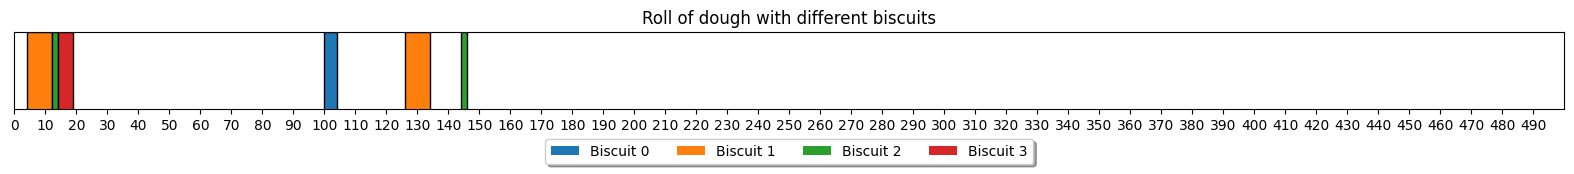

In [554]:
visualize_roll(roll_test)

#### We can see with our roll test that the biscuits are placed correctly and that the defects are present. Some biscuits can't be placed because of the defects.

# Implementing Hill Climbing method

## Why Hill Climbing is an Effective Method for Our Problem
Hill Climbing is an optimization technique makes small changes many times to improve step by step our solution. In our context of our biscuit manufacturing problem, Hill Climbing is particularly effective because it allows us to explore all the roll through many iterations and make adjustments to biscuit placements in order to increase bit by bit our total value. The ability to find better solutions from a given starting point, is ideal for problems like ours with many potential configurations.

#### To apply Hill Climbing to our biscuit placement problem, we'll follow these steps:

- Initial Solution :
We begin with an initial solution, Here we started by a simple random solution or a kind of greedy algorithm. Those simple initial solutions are starting point that serves as the basis for further optimization.

- Generating Neighbors :
From this initial solution, we generate 'neighbors' by making small modifications. These changes are made by taking randomly some group of biscuits and trying to find a better adjustments. The goal is to slightly alter the configuration in search of a better arrangement.

- Evaluation :
Each neighboring solution is evaluated to determine its effectiveness. In our case, this involves calculating the total value of the biscuits on the roll.

- Choosing the Best Solution :
If a neighboring solution proves to be better than the current roll. Meaning that its value is higher, we replace the current solution with this neighbor. 

- Iteration and Repetition :
This process is repeated until no further improvements are found, or until a predetermined stopping criterion is met (like a maximum number of iterations). This iterative nature allows Hill Climbing to explore various configurations, adapting and improving upon the arrangement of biscuits on the roll.

#### Let's start by creating our initial solution. In case the hill climbing get stuck in a local optimum, we will try adding some randomization to the initial solution. So we can see how this randomization can help us get a better solution.
For this initial solution we will randomly take a biscuit and place it at the first position where it can be placed. We will repeat this process until we can't place any more biscuits.

In [555]:
def generate_initial_solution(biscuits):
    """
    Generate an initial solution.
    
    Args:
        biscuits (list): the list of biscuits produced by the factory
        roll (Roll): the empty roll of dough
        
    Returns:
        Roll: the roll of dough with the biscuits placed on it
    """
    
    # We make a copy of the list of biscuits so we can remove the biscuit type if it can't be placed anymore
    biscuits = biscuits.copy()
    roll = Roll()
    while True:
        placed = False
        current_biscuit = np.random.choice(biscuits)
        for position in range(roll.length - current_biscuit.size + 1):
            if roll.place_biscuit(current_biscuit, position):
                placed = True
                break
        if not placed: # if the biscuit can't be placed after trying all the positions, we remove it from the list
            biscuits.remove(current_biscuit)
        if len(biscuits) == 0:
            break
    return roll

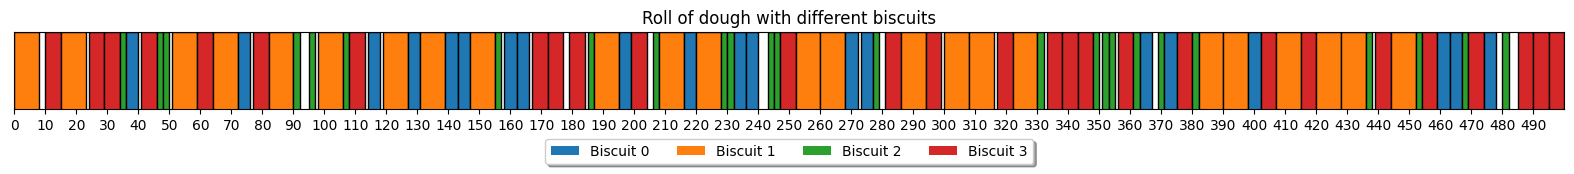

The total value of the roll is 657


In [556]:
roll_initial = generate_initial_solution(biscuits)
visualize_roll(roll_initial)
print(f'The total value of the roll is {roll_initial.total_value()}')

#### Let's see with several initial solutions what is the highest value we can get and the mean value of the solutions, out of 50 initial solutions.


In [557]:
def generate_initial_solutions(biscuits, n=50):
    """
    Generate n initial solutions.
    
    Args:
        biscuits (list): the list of biscuits produced by the factory
        n (int): the number of initial solutions to generate
        
    Returns:
        list: the list of rolls of dough with the biscuits placed on them
    """
    return [generate_initial_solution(biscuits) for _ in range(n)]

The highest value of the rolls is 681


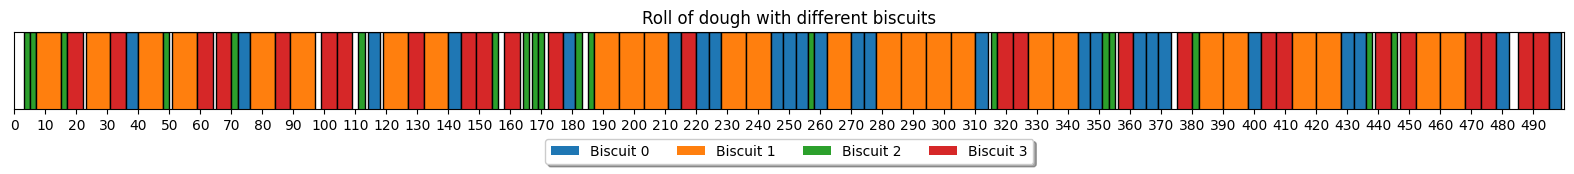

The mean value of the rolls is 652.1


In [558]:
rolls_initial = generate_initial_solutions(biscuits)

print(f'The highest value of the rolls is {max([roll.total_value() for roll in rolls_initial])}')
# let's display the best roll
visualize_roll(max(rolls_initial, key=lambda roll: roll.total_value()))
print(f'The mean value of the rolls is {np.mean([roll.total_value() for roll in rolls_initial])}')

#### To Keep a solution that will not be modified by randomness, we will use a greedy approach. We will place the biscuits with the highest value/size ratio first.
It's so we can judge the consistency of the hill climbing algorithm.

In [559]:
def generate_initial_greedy_solution(biscuits):
    """
    Generate an initial solution using a greedy approach.
    the best biscuit is the one with the highest value/size ratio
    that's in order, biscuit 3, biscuit 0, biscuit 1, biscuit 2
    
    Args:
        biscuits (list): the list of biscuits produced by the factory
        roll (Roll): the empty roll of dough
        
    Returns:
        Roll: the roll of dough with the biscuits placed on it
    """
    roll = Roll()
    biscuits = biscuits.copy()
    biscuits.sort(key=lambda biscuit: biscuit.value / biscuit.size, reverse=True)
    for biscuit in biscuits:
        for position in range(roll.length - biscuit.size + 1):
            if roll.place_biscuit(biscuit, position):
                continue
    return roll

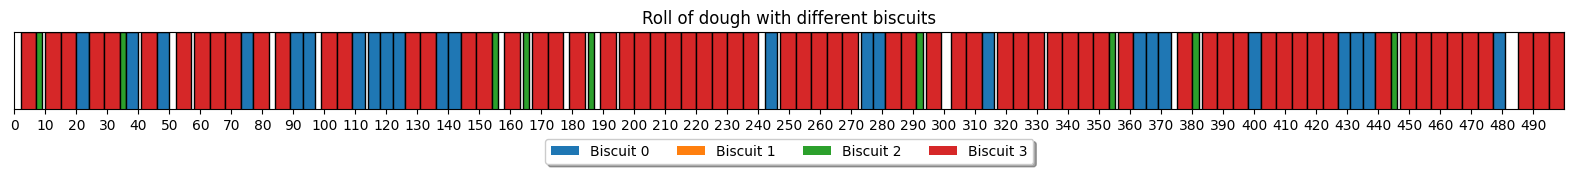

The total value of the roll is 705


In [560]:
roll_initial = generate_initial_greedy_solution(biscuits)
visualize_roll(roll_initial)
print(f'The total value of the roll is {roll_initial.total_value()}')

## Now let's implement the hill climbing algorithm.

#### Starting from an initial solution, we will generate a neighbor solution by trying to add a biscuit, move a biscuit or replace a biscuit by another type of biscuit. We will then evaluate the neighbor solution and if it is better than the current solution, we will replace the current solution by the neighbor solution. We will repeat this process until we can't find a better solution or we reach a maximum number of iterations.

In [561]:
def hill_climbing(roll, max_iterations=1000):
    """
    Apply the hill climbing algorithm to find the best solution.
    
    Args:
        biscuits (list): the list of biscuits produced by the factory
        max_iterations (int): the maximum number of iterations
        
    Returns:
        Roll: the best roll of dough found
    """
    for _ in range(max_iterations):
        # Generate a neighbor solution
        neighbor_roll = generate_neighbor_solution(roll)
        # Evaluate the neighbor solution
        if neighbor_roll.total_value() > roll.total_value(): # if the neighbor solution is better than the current solution
            roll = neighbor_roll # we replace the current solution by the neighbor solution
            # print(f'Current best roll has a value of {roll.total_value()}') # can be put under comment if we don't want to see the progress
            
    return roll

#### Let's define a function to generate a neighbor solution. We will randomly choose a group of biscuits and try to find a better placement for them.

Because of the constraints, moving a biscuit one by one is not very effective, so we will work by groups of biscuits.
For this neighbor solution, we will proceed as follows:
- We randomly choose the number of biscuits that are gonna be modified (between 2 and 5)
- We randomly choose a starting position for the group of biscuits
- We now try to fill again the space left by the group of biscuits according to some rules:
    - Since we want to maximize the value of the roll, we will try to place a biscuit of size 5 in the group, because it has the best value/size ratio. But since it's the only odd size biscuit, we have to be careful where we place it. In order to avoid empty spaces of 1 unit.
    - If the group size is odd, we try to place a biscuit of size 5 at the beginning or at the end of the group
    - If the group size is even, we try to place two biscuits of size 5 next to each other
    - We then fill the rest of the space with biscuits with good value/size ratio

In [562]:
import copy

def generate_neighbor_solution(roll):
    """
    Generate a neighbor solution.
    
    Args:
        roll (Roll): a suggestion of a roll of dough with the biscuits placed on it
        
    Returns:
        Roll: a new roll with modifications to the biscuits placement
    """
    
    roll = copy.deepcopy(roll)
    rand = np.random.randint(2, 6) # we choose a random number between 2 and 5
    
    # We try to be careful not to choose a starting position that is too close to the end of the roll
    start_position_max = roll.length - sum([assigned_biscuit[0].size for assigned_biscuit in roll.assigned_biscuits[-rand:]])

    # We choose a random starting position for the group
    start_position = np.random.randint(0, start_position_max + 1)
    
    # We get the group of biscuits from the starting position
    group = []
    for assigned_biscuit in roll.assigned_biscuits:
        if start_position <= assigned_biscuit[1] and len(group) < rand:
            group.append(assigned_biscuit)
    
    # We calculate the total size of the group
    group_size = group[-1][1] + group[-1][0].size - group[0][1]
    
    # We first remove the biscuits from the roll
    for assigned_biscuit in group:
        roll.remove_biscuit(assigned_biscuit[0], assigned_biscuit[1])
        
    # We will fill smartly the space left by the group of biscuits
    roll = fill_small_spaces(roll, group_size, start_position)
    
    return roll

This function follows the rules we defined earlier to fill the space left by the group of biscuits.

In [563]:
def fill_small_spaces(roll, group_size, start_position):
    #Let's look at how to place new biscuits in the group
    if group_size % 2 == 1: 
        # For odd group size, if we are able to put a biscuit of size 5 at the beginning or at the end of the group, we will be left by an even space to fill which is easier for us
        # We try to place a biscuit of size 5 at the beginning of the group
        if roll.place_biscuit(biscuits[3], start_position):
            # We next need to fill the rest with the space to get no empty space in the group
            # We try to put next to the biscuit of size 5 another biscuit with good value/size ratio
            for position in range(start_position + 5, start_position + group_size - 5 + 1, 2):
                for biscuit in biscuits:
                    if roll.place_biscuit(biscuit, start_position + 5):
                        break
        else: # if we can't place a biscuit of size 5 at the beginning of the group
            # We try to place a biscuit of size 5 at the end of the group
            if roll.place_biscuit(biscuits[3], start_position + group_size - 5):
                # We next need to fill the rest with the space to get no empty space in the group
                # We try to put right before the biscuit of size 5 another biscuit with good value/size ratio
                for position in range(start_position, start_position + group_size - 5, 2):
                    for biscuit in biscuits:
                        if roll.place_biscuit(biscuit, position):
                            break
                            
    else: # if the group size is even
        # We try to place somewhere two biscuits of size 5 next to each other to keep the space left by the group even
        for position in range(start_position, start_position + group_size - 5 + 1, 2):
            if roll.check_constraints(biscuits[3], position) and roll.check_constraints(biscuits[3], position + 5):
                roll.place_biscuit(biscuits[3], position)
                roll.place_biscuit(biscuits[3], position + 5)
            # We next need to fill the rest with the space to get no empty space in the group
            # We try to put right before the biscuit of size 5 another biscuit with good value/size ratio
            for position in range(start_position, start_position + group_size - 10 + 1, 2):
                for biscuit in biscuits:
                    if roll.place_biscuit(biscuit, position):
                        break
                        
    return roll

The total value of the initial is 653


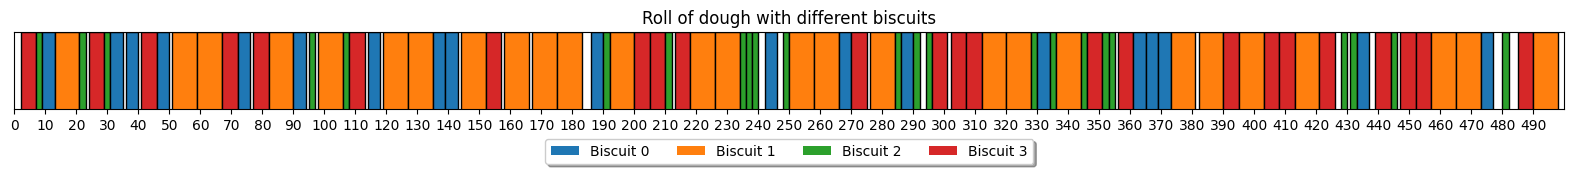

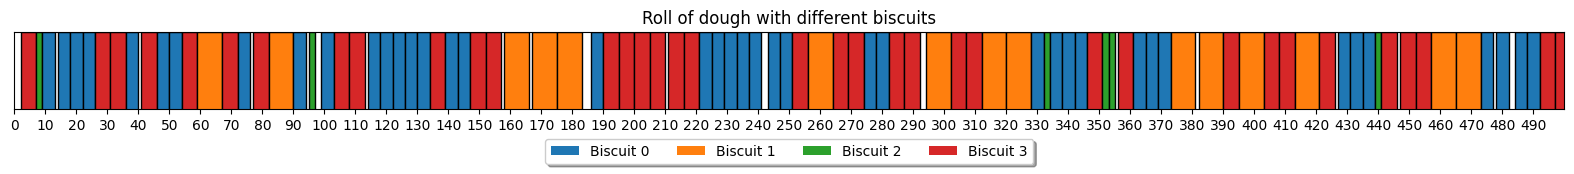

The total value of the final roll is 720


In [577]:
roll_initial =generate_initial_solution(biscuits)
print(f'The total value of the initial is {roll_initial.total_value()}')
visualize_roll(roll_initial)
roll_hill_climbing = hill_climbing(roll_initial)
visualize_roll(roll_hill_climbing)
print(f'The total value of the final roll is {roll_hill_climbing.total_value()}')

I try to run 50 times hill climbing, you can skip this part taking a some time to run

In [565]:
rolls_hill_climbing = [hill_climbing(generate_initial_solution(biscuits)) for _ in range(50)]
print(f'The highest value of the rolls is {max([roll.total_value() for roll in rolls_hill_climbing])}')
print(f'The mean value of the rolls is {np.mean([roll.total_value() for roll in rolls_hill_climbing])}')

The highest value of the rolls is 735
The mean value of the rolls is 715.54


#### By trying several times the hill climbing algorithm with this random initial solution, we can see that it always find a better solution. But the result depend greatly on the initial solution. The results can vary from 700 to 730, which is not very consistent. It's still went up by 50-70 in average. which is not bad.


The total value of the initial is 705


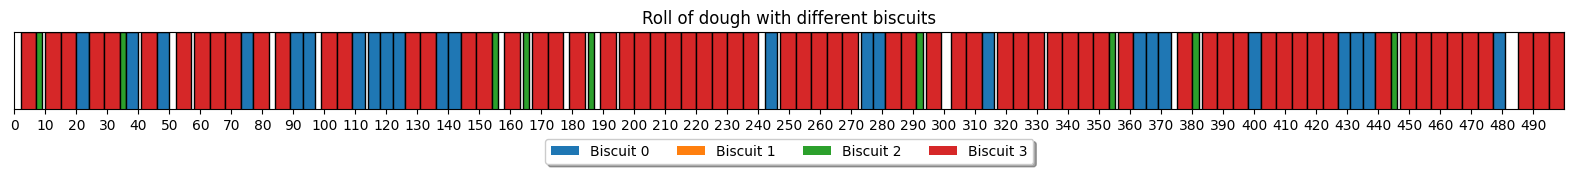

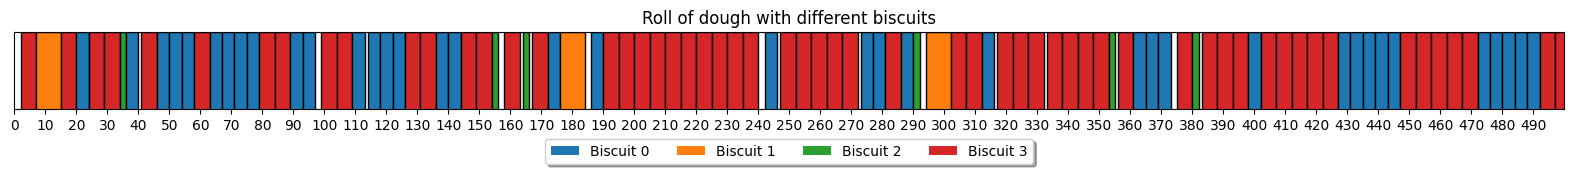

The total value of the final roll is 734


In [578]:
roll_greedy = generate_initial_greedy_solution(biscuits)
print(f'The total value of the initial is {roll_greedy.total_value()}')
visualize_roll(roll_greedy)
roll_hill_climbing = hill_climbing(roll_greedy)
visualize_roll(roll_hill_climbing)
print(f'The total value of the final roll is {roll_hill_climbing.total_value()}')

#### With the greedy initial solution, we can see that the hill climbing algorithm is more consistent. The results vary from 730 to 740, which is a lot better than the random initial solution. The results are also better.

# Implementing Constraint Satisfaction Problem

#### Why Constraint Satisfaction Problem is an Effective Method for Our Problem

In [567]:
from ortools.sat.python import cp_model

In [568]:
def create_csp_model(biscuits, roll_length, defects):
    """
    Create and return a CSP model for the biscuit placement problem.
    
    Args:
        biscuits (list): the list of biscuits produced by the factory
        roll_length (int): the length of the roll
        defects (list): the list of defects in the roll
        
    Returns:
        cp_model.CpModel: the CSP model
    """
    model = cp_model.CpModel()
    
    # We add the variables to the model
    add_biscuit_variables(model, biscuits, roll_length)
    
    # We add the constraints to the model
    add_constraints(model, biscuits, roll_length, defects)
    
    return model

In [569]:
def add_biscuit_variables(model, biscuits, roll_length):
    """
    Add the variables to the model, representing the possible positions for each type of biscuit on the roll.
    
    Args:
        model (cp_model.CpModel): the CSP model
        biscuits (list): the list of biscuits produced by the factory
        roll_length (int): the length of the roll
    """
    # We create a dictionary to store the variables
    model.variables = {}
    
    # The value of the variable will be 1 if the biscuit is placed at the position, 0 otherwise
    for biscuit in biscuits:
        for position in range(roll_length - biscuit.size + 1):
            model.variables[(biscuit, position)] = model.NewBoolVar(f'{biscuit}_{position}')
            
    return model

In [579]:
def add_constraints(model, biscuits, roll_length, defects):
    """
    Add the constraints to the model
    
    Args:
        model (cp_model.CpModel): the CSP model
        biscuits (list): the list of biscuits produced by the factory
        roll_length (int): the length of the roll
        defects (list): the list of defects in the roll
        
    Returns:
        cp_model.CpModel: the CSP model
    """
    
    # We add the constraints to the model
    for biscuit in biscuits:
        for position in range(roll_length - biscuit.size + 1):
            model.Add(model.variables[(biscuit, position)] == 1).OnlyEnforceIf(model.variables[(biscuit, position)]) 
            model.Add(model.variables[(biscuit, position)] == 0).OnlyEnforceIf(model.variables[(biscuit, position)].Not())
            
    # We add the constraint that there is no overlap in biscuit placement
    """for biscuit1 in biscuits:
        for position1 in range(roll_length - biscuit1.size + 1):
            for biscuit2 in biscuits:
                for position2 in range(roll_length - biscuit2.size + 1):
                    if biscuit1 != biscuit2 or position1 != position2:
                        # We add the constraint that the two biscuits can't overlap
                        model.AddBoolOr([model.variables[(biscuit1, position1)].Not(), model.variables[(biscuit2, position2)].Not()])"""
                        
    # We add the constraint that each biscuit placed on the roll contains fewer defects (or an equal number) of each class than its thresholds permit
    """for biscuit in biscuits:
        for position in range(roll_length - biscuit.size + 1):
            for defect_class in ['a', 'b', 'c']:  
                defect_count = sum(model.NewBoolVar(f'defect_{position}_{defect_class}_{i}')
                                   for i, defect in enumerate(defects)
                                   if defect.classe == defect_class and position <= float(defect.position) < position + biscuit.size)
                model.Add(defect_count <= biscuit.defects_threshold[defect_class])"""
            

            
    return model

In [571]:
def solve_csp(model):
    """
    Solve the CSP model and return the optimal solution (if it exists).
    
    Args:
        model (cp_model.CpModel): the CSP model to solve
        
    Returns:
        cp_model.CpSolver: the solver
        cp_model.CpSolverStatus: the status of the solver
        dict: the solution of the CSP model
    """
    solver = cp_model.CpSolver()
    status = solver.Solve(model)
    solution = None
    if status == cp_model.OPTIMAL:
        solution = {key: solver.Value(value) for key, value in model.variables.items()}
    return solver, status, solution

In [572]:
def extract_solution(model, biscuits, roll_length):
    """
    Extract and return the solution in a readable form, for example, a list of biscuits with their assigned positions.
    
    Args:
        model (cp_model.CpModel): the solved CSP model
        biscuits (list): the list of biscuits produced by the factory
        roll_length (int): the length of the roll
        
    Returns:
        list: the list of assigned biscuits with the type of biscuit and its starting position
    """
    assigned_biscuits = []
    for biscuit in biscuits:
        for position in range(roll_length - biscuit.size + 1):
            if solver.Value(model.variables[(biscuit, position)]) == 1:
                assigned_biscuits.append((biscuit, position))
    return assigned_biscuits

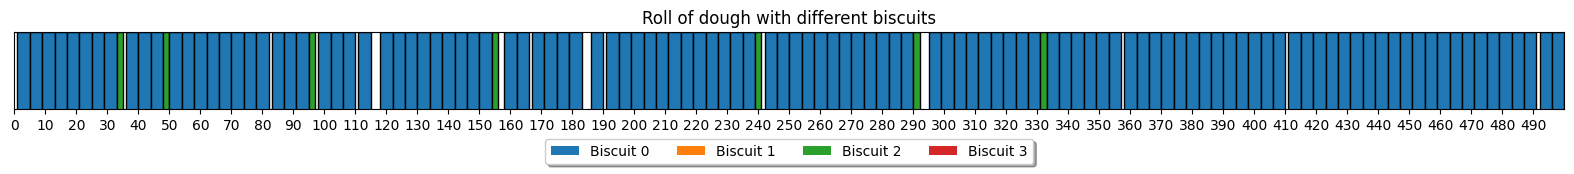

The total value of the roll is 703


In [580]:
model = create_csp_model(biscuits, 500, defects)
solver, status, solution = solve_csp(model)
if status == cp_model.OPTIMAL:
    assigned_biscuits = extract_solution(model, biscuits, 500)
    roll_csp = Roll()
    for assigned_biscuit in assigned_biscuits:
        roll_csp.place_biscuit(assigned_biscuit[0], assigned_biscuit[1])
    visualize_roll(roll_csp)
    print(f'The total value of the roll is {roll_csp.total_value()}')

we have a problem in the constraints 
